# DSI Summary Research Program Initial Explore
by Qinlian Yang, Vanderbilt University

##  `Linear Methods `

### Import Packages

In [212]:
# process data
import pandas as pd
import numpy as np

# correlation assumptions
import statsmodels.tsa.api as smt

# split data to train and test
from sklearn.model_selection import train_test_split

import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import r2_score
import seaborn as sbn
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# catch warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", module="matplotlib")

In [213]:
stock = pd.read_csv("AppleCompanyStock.csv")

In [214]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    950 non-null    int64  
 1   month   950 non-null    int64  
 2   open    950 non-null    float64
 3   high    950 non-null    float64
 4   low     950 non-null    float64
 5   close   950 non-null    float64
 6   volume  950 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 52.1 KB


In [215]:
stock.head()

,year,month,open,high,low,close,volume
0,2018,3,177.32,177.470,173.66,175.82,46812368
1,2018,3,180.29,183.500,177.62,178.02,151720299
2,2018,3,175.21,180.000,174.27,179.98,138442235
3,2018,3,176.35,180.615,172.45,176.21,196432091
4,2018,2,172.05,175.650,171.01,175.50,133197874


In [216]:
stock.tail()

,year,month,open,high,low,close,volume
945,2000,2,108.00,117.12,105.94,108.75,14859900
946,2000,2,101.00,110.00,94.50,108.00,21289500
947,2000,1,108.44,114.19,100.62,101.62,18470300
948,2000,1,101.00,121.50,100.44,111.31,30213200
949,2000,1,102.00,102.25,86.50,100.44,29872700


In [217]:
# Apple stock data, monthly from Jan 2000 to Dec 2018
stock.describe()

,year,month,open,high,low,close,volume
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,9.500000e+02
mean,2008.631579,6.497895,168.952003,174.218120,164.176523,169.350997,1.092915e+08
std,5.259449,3.463112,167.253584,171.648176,163.694731,167.548177,8.144325e+07
min,2000.000000,1.000000,13.130000,13.630000,12.720000,13.120000,5.515100e+06
25%,2004.000000,3.000000,46.232500,48.335000,44.840000,46.130000,4.347195e+07
50%,2009.000000,6.500000,111.405000,114.735000,108.230000,111.940000,9.234840e+07
75%,2013.000000,9.750000,195.610000,202.487500,190.272500,195.240000,1.511180e+08
max,2018.000000,12.000000,699.350000,705.070000,693.620000,700.095000,5.003630e+08


# Part 1: Univariate and Bivariate Analysis(EDA)

#### Filter out closing price and volume

In [218]:
stock = stock.loc[:,["year", "month", "close", "volume"]]
stock.head()

,year,month,close,volume
0,2018,3,175.82,46812368
1,2018,3,178.02,151720299
2,2018,3,179.98,138442235
3,2018,3,176.21,196432091
4,2018,2,175.50,133197874


#### Take the last closing price and vloume for each month

Before we start to analyse our data we need a single data point for each month and year. We will use the **last** value for each month for doing so. The reason we are not averaging it out is because we can loose important information that way. We will look into this shortly.

In [219]:
# group by year and month
stock_agg = stock.groupby(["year","month"]).tail(1)

# sort values by year and month
stock_agg = stock_agg.sort_values(by=["year", "month"],ascending=True).reset_index()

# replace the index
stock_agg.drop(axis=1,columns='index',inplace=True)

# combine year and month to a single string
stock_agg["yrmo"] = stock_agg["year"].map(str)+stock_agg["month"].map(str)

stock_agg.head()

,year,month,close,volume,yrmo
0,2000,1,100.44,29872700,20001
1,2000,2,108.00,21289500,20002
2,2000,3,128.00,21508200,20003
3,2000,4,131.75,17398400,20004
4,2000,5,113.12,14607300,20005


<AxesSubplot:xlabel='yrmo', ylabel='close'>

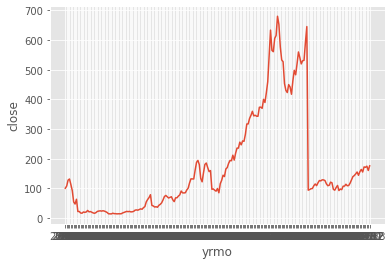

In [220]:
sbn.lineplot(x = "yrmo", y = "close", data=stock_agg, sort=False)

#### Plot the closing price vs time

In [221]:
def get_scatterplot(stock,yvar,ylim):
    fig = plt.figure(figsize=(20,14))
    for i,p in zip(range(4), range(0,220, 55)):
        plt.subplot(221+i)
        plt.xticks(rotation=90)
        ax = sbn.lineplot(x="yrmo", y=yvar,data=stock[p:p+55], sort=False)
        plt.xlabel("Year-Month")
        ax.set_ylim(ylim)

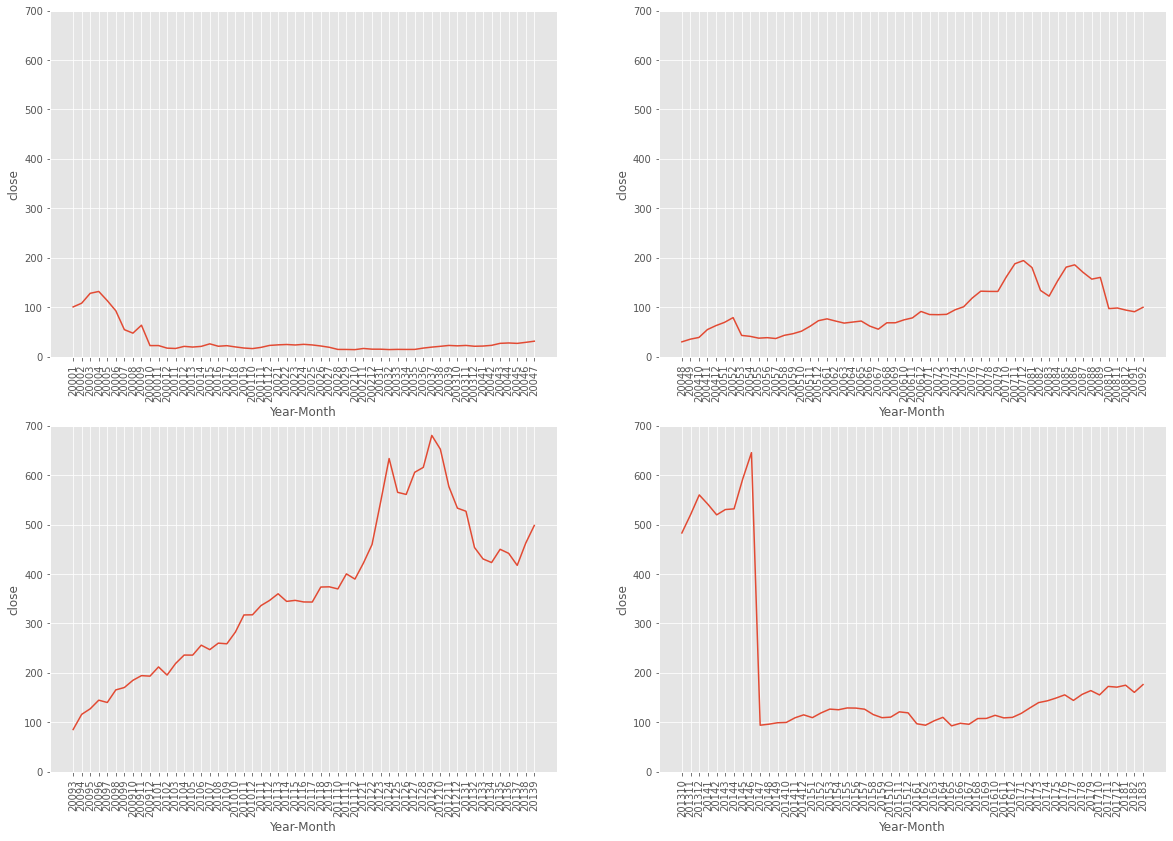

In [222]:
get_scatterplot(stock_agg,"close",[0,700])

- Iphone 3gs and macbook pro came out around May-June 2009 when the stock price rose meteorically.
- In June 2014 there was split in apple stock in ratio of 1:7 so each share was divided into 7 shares of equal value.

### Split Adjusted Stock Price

##### Stock price upto June 2014 needs to be divided by 7 in order to determine the split adjusted price and bring all values to same scale.

In [223]:
idx = stock_agg.index[(stock_agg.year==2014) & (stock_agg.month==6)].tolist()[0]

In [224]:
sad = stock_agg.loc[0:idx,'close']/7
sad = sad.append(stock_agg.loc[idx+1:len(stock_agg),'close'])

In [225]:
stock_agg['close'] = sad

In [226]:
stock_agg[(stock_agg.year<=2014)].tail(10)

,year,month,close,volume,yrmo
170,2014,3,75.777143,39435800,20143
171,2014,4,75.974286,35265900,20144
172,2014,5,84.654286,67823800,20145
173,2014,6,92.224286,58974500,20146
174,2014,7,94.030000,139168800,20147
175,2014,8,96.130000,236825000,20148
176,2014,9,98.970000,322672500,20149
177,2014,10,99.620000,247749150,201410
178,2014,11,109.010000,199952812,201411
179,2014,12,115.000000,266701088,201412


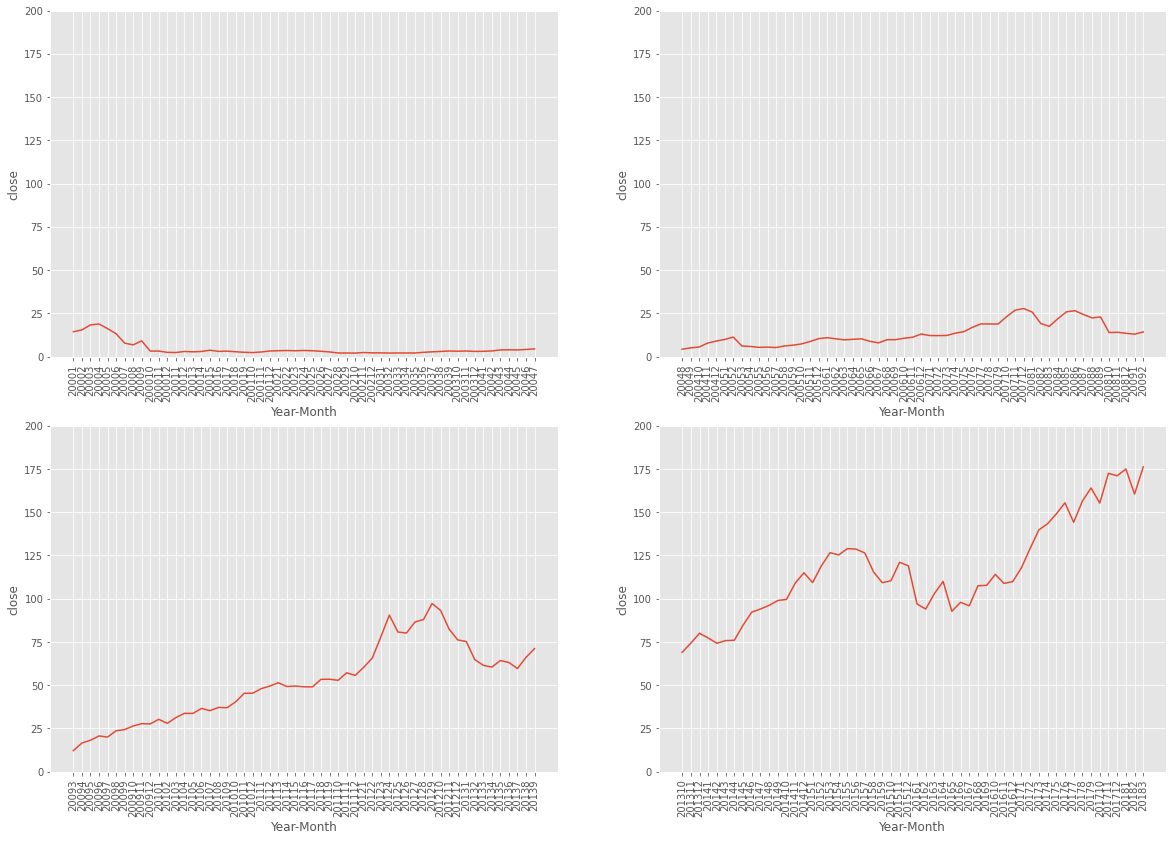

In [227]:
get_scatterplot(stock_agg,"close", [0,200])

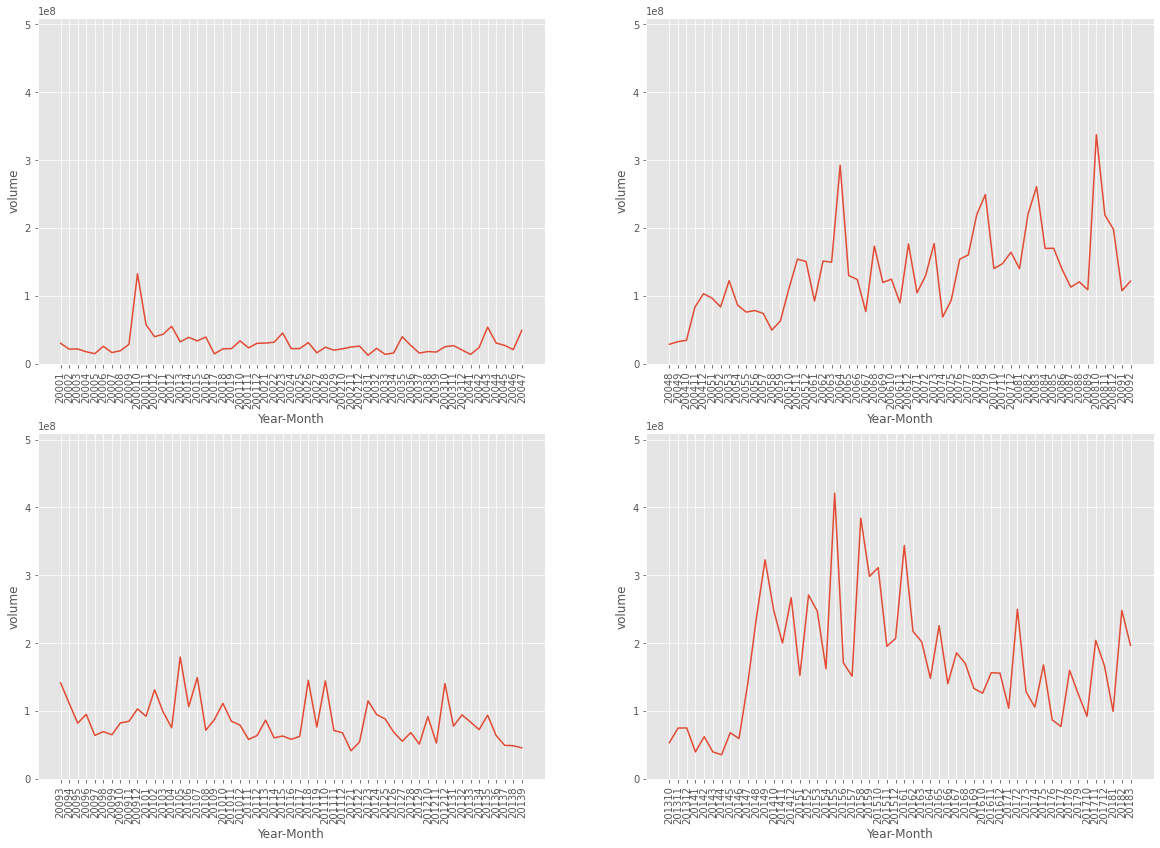

In [228]:
get_scatterplot(stock_agg,"volume",[0,510000000])

### Split Adjusted Volume

In [229]:
sav = stock_agg.loc[0:idx,'volume']*7
sav = sav.append(stock_agg.loc[idx+1:len(stock_agg),'volume'])

In [230]:
stock_agg['volume'] = sav

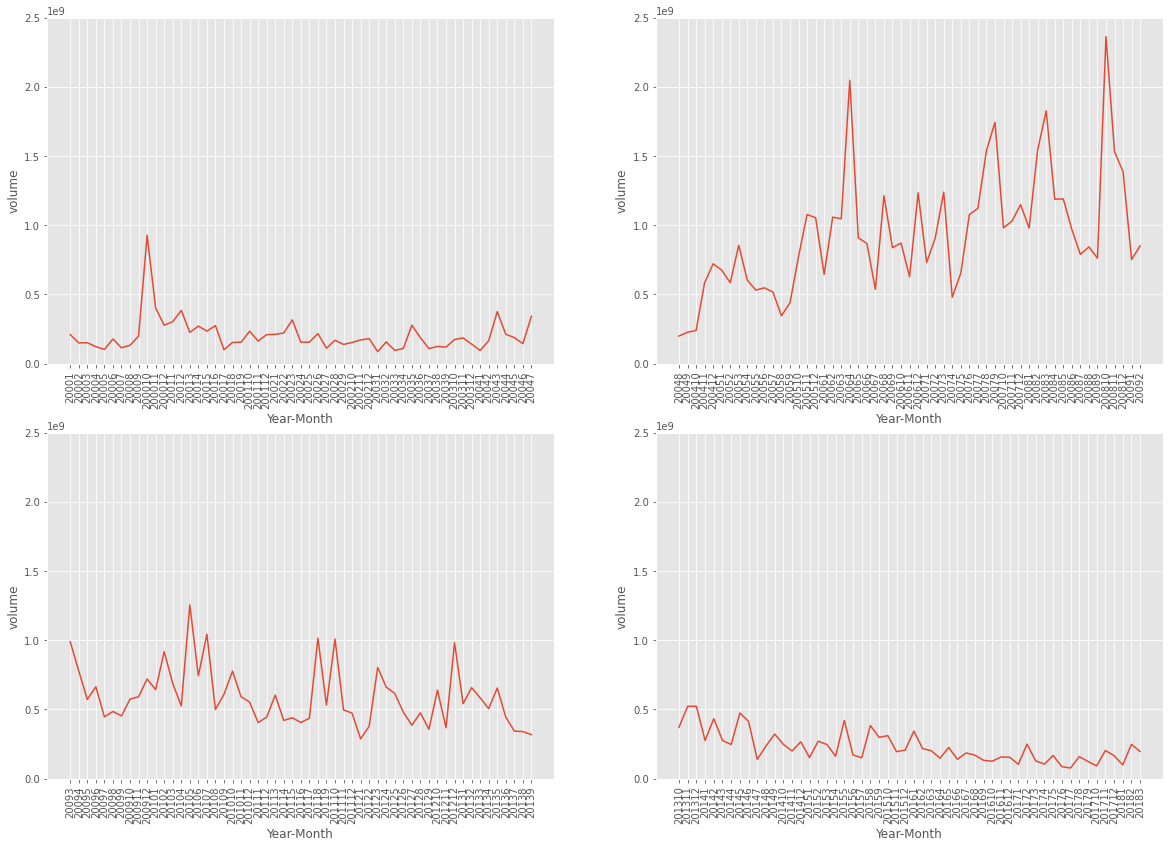

In [231]:
get_scatterplot(stock_agg,"volume",[0,2500000000])

- If we see **2008 October** there is a large surge in volume which corresponds to a huge sell off of apple stock and corresponding fall in the price. This implies a negative correlation between volume and closing price. Let's confirm this with the correlation heatmap.

### Correlation Heatmap

In [232]:
corr = stock_agg[["close","volume"]].corr()

<AxesSubplot:>

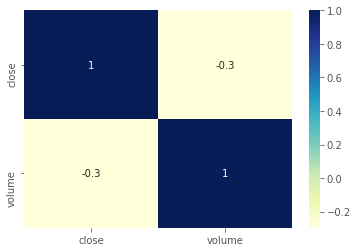

In [233]:
sbn.heatmap(corr, annot=True, cmap="YlGnBu")

## 1. Lags, Moving Average and RSI based Features

- Moving average is the average price of the stock over past n time periods. It indicates movement of the stock and smoothens the price changes.


- RSI or relative strength indicator is the indicator of the fact that whether the stock is oversold or overbought.


- If the RSI is near 0 that means that the stock is over sold and is likely to rebound from its recent lows.


- if the RSI is near 100 it means that the stock is over bought and is likely to reverse to a downward trajectory.

In [234]:
# shift()
# Syntax:DataFrame.shift(periods=1, freq=None, axis=0)
# Parameters :
# periods : Number of periods to move, can be positive or negative
# freq : DateOffset, timedelta, or time rule string, optional Increment to use from the tseries module or time rule (e.g. ‘EOM’). See Notes
# axis : {0 or ‘index’, 1 or ‘columns’}

# Return : shifted : DataFrame

for i in range(1,7):
    stock_agg['close_lag' + str(i)] = stock_agg['close'].shift(i)

In [235]:
stock_agg.head()

,year,month,close,volume,yrmo,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6
0,2000,1,14.348571,209108900,20001,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,2,15.428571,149026500,20002,14.348571,NaN,NaN,NaN,NaN,NaN
2,2000,3,18.285714,150557400,20003,15.428571,14.348571,NaN,NaN,NaN,NaN
3,2000,4,18.821429,121788800,20004,18.285714,15.428571,14.348571,NaN,NaN,NaN
4,2000,5,16.160000,102251100,20005,18.821429,18.285714,15.428571,14.348571,NaN,NaN


In [236]:
import talib

Formula for RS = average gain over n periods/average loss over n periods

RSI = 100 - (100/(1 + RS))

In [237]:
for n in [3,6,9,12]:
    
    # SMA stands for "simple moving average"
    # Create the moving average and divide by the close price to average it out
    stock_agg['ma_' + str(n)] = talib.SMA(stock_agg['close'].values,timeperiod=n)/ stock_agg['close']
    
    # Create the RSI indicator
    stock_agg['rsi_' + str(n)] = talib.RSI(stock_agg['close'].values, timeperiod=n)
    
stock_agg.head(10)

,year,month,close,volume,yrmo,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6,ma_3,rsi_3,ma_6,rsi_6,ma_9,rsi_9,ma_12,rsi_12
0,2000,1,14.348571,209108900,20001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,2,15.428571,149026500,20002,14.348571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,3,18.285714,150557400,20003,15.428571,14.348571,NaN,NaN,NaN,NaN,0.876146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,4,18.821429,121788800,20004,18.285714,15.428571,14.348571,NaN,NaN,NaN,0.930424,100.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,5,16.160000,102251100,20005,18.821429,18.285714,15.428571,14.348571,NaN,NaN,1.098745,52.839423,NaN,NaN,NaN,NaN,NaN,NaN
5,2000,6,13.222857,177703400,20006,16.160000,18.821429,18.285714,15.428571,14.348571,NaN,1.215176,29.673506,1.213393,NaN,NaN,NaN,NaN,NaN
6,2000,7,7.777143,113649200,20007,13.222857,16.160000,18.821429,18.285714,15.428571,14.348571,1.592701,13.370628,1.922208,28.825262,NaN,NaN,NaN,NaN
7,2000,8,6.768571,132244700,20008,7.777143,13.222857,16.160000,18.821429,18.285714,15.428571,1.367525,11.600109,1.995392,26.739658,NaN,NaN,NaN,NaN
8,2000,9,9.062857,198487100,20009,6.768571,7.777143,13.222857,16.160000,18.821429,18.285714,0.868327,39.111656,1.320644,38.822580,1.469683,NaN,NaN,NaN
9,2000,10,3.170000,926824500,200010,9.062857,6.768571,7.777143,13.222857,16.160000,18.821429,1.998047,17.785803,2.952756,25.738445,3.809924,27.383086,NaN,NaN


The relative strength index is a momentum oscillator commonly used to predict when a company is oversold or overbought. 
The calculation process is straightforward:

1. Observe the last 14 closing prices of a stock.
2. Determine whether the current day’s closing price is higher or lower than the previous day.
3. Calculate the average gain and loss over the last 14 days.
4. Compute the relative strength (RS): (AvgGain / AvgLoss)
5. Compute the relative strength index (RSI): (100–100 / ( 1 + RS))

The RSI will then be a value between 0 and 100. It is widely accepted that when the RSI is 30 or below, the stock is undervalued and when it is 70 or above, the stock is overvalued.

<AxesSubplot:>

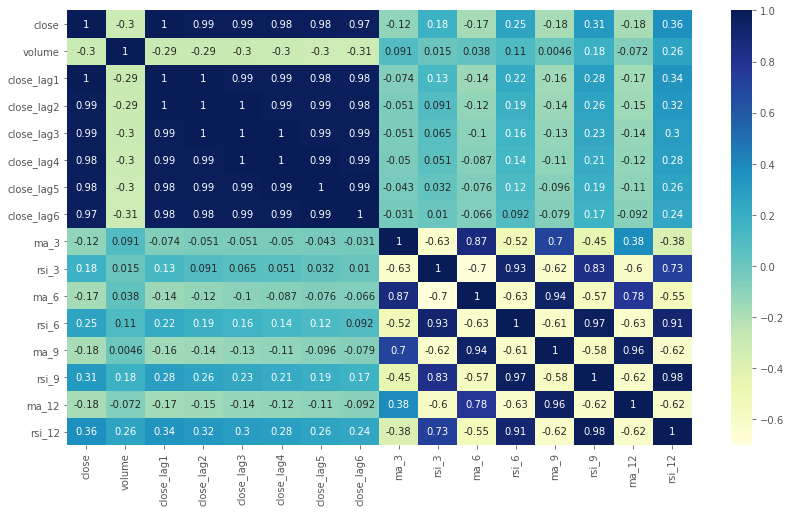

In [238]:
plt.figure(figsize=(14,8))
corr = stock_agg.drop(columns=["year","month","yrmo"]).corr()
sbn.heatmap(data=corr, annot=True, cmap="YlGnBu")

## 2. Data Cleaning and Outlier Detection

#### Check for null or na on columns

In [239]:
stock_agg.isna().sum()

year           0
month          0
close          0
volume         0
yrmo           0
close_lag1     1
close_lag2     2
close_lag3     3
close_lag4     4
close_lag5     5
close_lag6     6
ma_3           2
rsi_3          3
ma_6           5
rsi_6          6
ma_9           8
rsi_9          9
ma_12         11
rsi_12        12
dtype: int64

In [240]:
stock_agg.dropna(inplace=True)
len(stock_agg)

207

In [241]:
stock_agg.isna().sum()

year          0
month         0
close         0
volume        0
yrmo          0
close_lag1    0
close_lag2    0
close_lag3    0
close_lag4    0
close_lag5    0
close_lag6    0
ma_3          0
rsi_3         0
ma_6          0
rsi_6         0
ma_9          0
rsi_9         0
ma_12         0
rsi_12        0
dtype: int64

In [242]:
# Computing IQR
Q1 = stock_agg[["close","volume"]].quantile(0.25)
Q3 = stock_agg[["close","volume"]].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

close     7.715500e+01
volume    4.739815e+08
dtype: float64


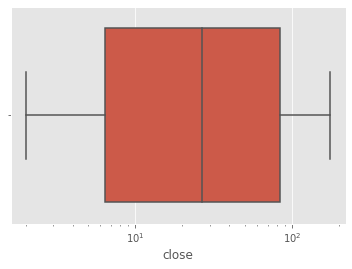

In [243]:
sbn.boxplot("close", data=stock_agg)
plt.xscale("log")

In [244]:
len(stock_agg[stock_agg.close>Q3['close']+1.5*IQR[0]]) * 100/len(stock_agg)

0.0

In [245]:
len(stock_agg[stock_agg.close<Q1['close']-1.5*IQR[0]]) * 100/len(stock_agg)

0.0

<AxesSubplot:xlabel='volume'>

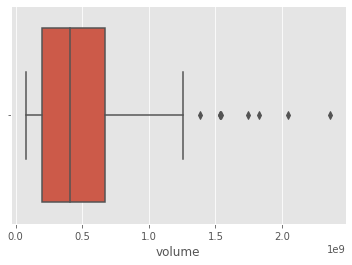

In [246]:
sbn.boxplot("volume", data=stock_agg)

In [247]:
len(stock_agg[stock_agg.volume>Q3['volume'] + 1.5*IQR[1]]) * 100/len(stock_agg)

3.864734299516908

In [248]:
# drop outliers
stock_agg = stock_agg[stock_agg.volume < stock_agg.volume.quantile(.95)]

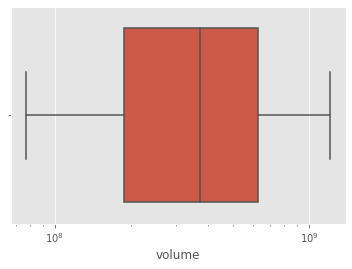

In [249]:
sbn.boxplot("volume", data=stock_agg)
plt.xscale("log")

In [250]:
len(stock_agg[stock_agg.volume>Q3['volume'] + 1.5*IQR[1]]) * 100/len(stock_agg)

0.0

## 3. Creating the features and independent variable

In [251]:
stock_agg.head()

,year,month,close,volume,yrmo,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6,ma_3,rsi_3,ma_6,rsi_6,ma_9,rsi_9,ma_12,rsi_12
12,2001,1,2.338571,302642200,20011,2.437143,3.178571,3.170000,9.062857,6.768571,7.777143,1.133781,15.092585,1.921095,24.078293,3.046291,26.265370,4.156791,26.507573
13,2001,2,2.945714,384461700,20012,2.338571,2.437143,3.178571,3.170000,9.062857,6.768571,0.873747,31.511451,1.308843,28.859313,1.919981,28.943696,2.946896,28.363782
14,2001,3,2.750000,224981400,20013,2.945714,2.338571,2.437143,3.178571,3.170000,9.062857,0.973853,28.817006,1.019394,28.173033,1.633478,28.567385,2.685844,28.114077
15,2001,4,2.941429,270841900,20014,2.750000,2.945714,2.338571,2.437143,3.178571,3.170000,0.978792,36.751619,0.940100,30.123383,1.344504,29.574912,2.061154,28.783068
16,2001,5,3.678571,234143700,20015,2.941429,2.750000,2.945714,2.338571,2.437143,3.178571,0.849061,61.524273,0.774369,37.913568,0.981748,33.630256,1.365372,31.462473


In [252]:
import requests, bs4

In [253]:
req = requests.get("https://en.wikipedia.org/wiki/List_of_Apple_Inc._media_events")
soup = bs4.BeautifulSoup(req.text, "html.parser")
spans = soup.find_all('span', attrs={'class':'toctext'})
for span in spans[0:5]:
    print(span.text)

Venues
2005
WWDC 2005 (June 6–10, 2005)
2006
Apple Special Event (February 28, 2006)


In [254]:
import calendar
months = list(calendar.month_name)[1:]

In [255]:
events = []
for span in spans:
    stxt = span.text
    for i, month in enumerate(months):
        if month in stxt:
            yr = stxt[-5:-1]
            events.append(yr+str(i+1))
print(events)

['20056', '20062', '20068', '20069', '20071', '20081', '20086', '20089', '20096', '20101', '20104', '20106', '20109', '20113', '20116', '201110', '20123', '20126', '20129', '201210', '20136', '20139', '201310', '20146', '20149', '201410', '20153', '20156', '20159', '20163', '20166', '20169', '201610', '20176', '20179', '20183', '20186', '20189', '201810', '20193', '20196', '20199', '201912', '20206', '20209', '202010', '202011', '20214', '20216']


In [256]:
# merge the events to the dataframe

stock_agg['event'] = stock_agg['yrmo'].apply(lambda ymo : 1 if ymo in events else 0)
stock_agg[['yrmo','event']].tail(7)

,yrmo,event
212,20179,1
213,201710,0
214,201711,0
215,201712,0
216,20181,0
217,20182,0
218,20183,1


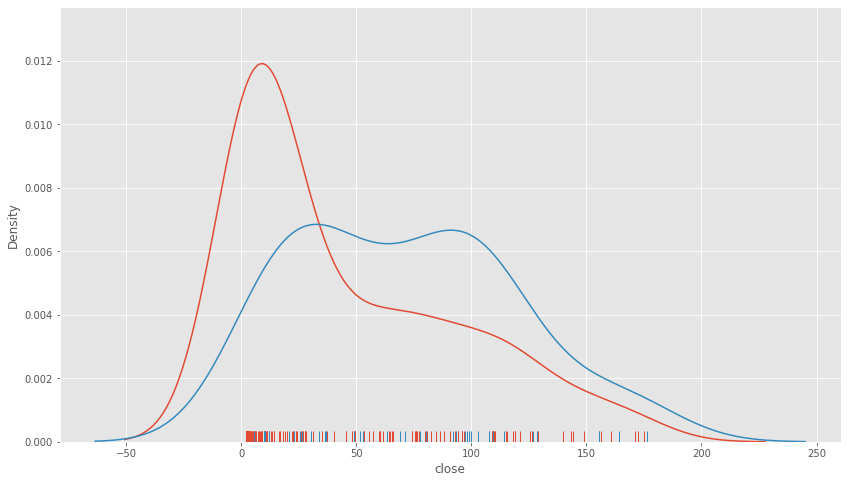

In [257]:
plt.figure(figsize=(14,8))
sbn.distplot(stock_agg.loc[stock_agg.event==0,'close'], hist=False, rug=True,label='No Events')
sbn.distplot(stock_agg.loc[stock_agg.event==1,'close'], hist=False, rug=True, label='Events')
plt.show()

In [258]:
print("Event Mean ",stock_agg.loc[stock_agg.event==1,:]['close'].mean())
print("Non Event Mean ",stock_agg.loc[stock_agg.event==0,:]['close'].mean())

Event Mean  71.09878174603176
Non Event Mean  45.32377758928571


<AxesSubplot:>

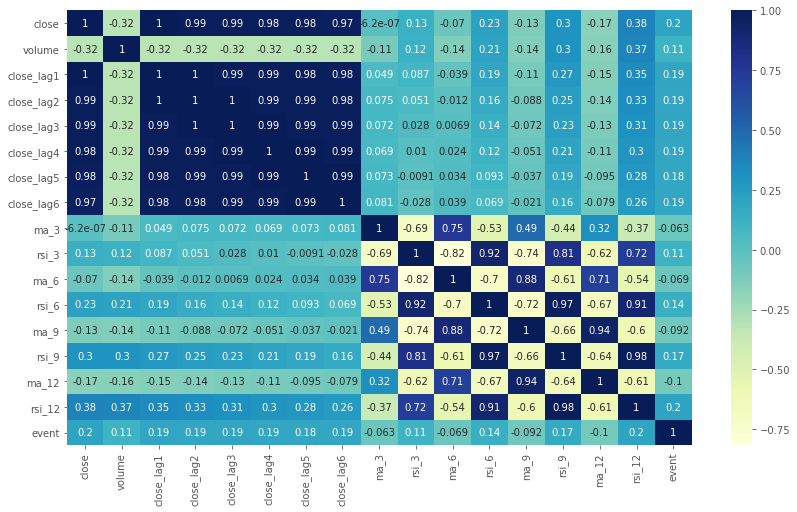

In [259]:
plt.figure(figsize=(14,8))
corr = stock_agg.drop(columns=["year","month","yrmo"]).corr()
sbn.heatmap(data=corr, annot=True, cmap="YlGnBu")

So we do see a positive correlation between the events and closing price, so this could be a driver variable.

We are trying to predict the closing price so it will become our independent variable.

## 4. Prepare The Data For Modelling

Dropping **time** columns as they do not have significance as a driver for closing price.

In [260]:
stock_final = stock_agg.drop(columns = ["year","month","yrmo"], axis = 1)

In [261]:
stock_final.head()

,close,volume,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6,ma_3,rsi_3,ma_6,rsi_6,ma_9,rsi_9,ma_12,rsi_12,event
12,2.338571,302642200,2.437143,3.178571,3.170000,9.062857,6.768571,7.777143,1.133781,15.092585,1.921095,24.078293,3.046291,26.265370,4.156791,26.507573,0
13,2.945714,384461700,2.338571,2.437143,3.178571,3.170000,9.062857,6.768571,0.873747,31.511451,1.308843,28.859313,1.919981,28.943696,2.946896,28.363782,0
14,2.750000,224981400,2.945714,2.338571,2.437143,3.178571,3.170000,9.062857,0.973853,28.817006,1.019394,28.173033,1.633478,28.567385,2.685844,28.114077,0
15,2.941429,270841900,2.750000,2.945714,2.338571,2.437143,3.178571,3.170000,0.978792,36.751619,0.940100,30.123383,1.344504,29.574912,2.061154,28.783068,0
16,3.678571,234143700,2.941429,2.750000,2.945714,2.338571,2.437143,3.178571,0.849061,61.524273,0.774369,37.913568,0.981748,33.630256,1.365372,31.462473,0


#### Normalise the data

In [262]:
stock_n = stock_final.loc[:, stock_final.columns != 'close']

In [263]:
stock_n = (stock_n - stock_n.mean()) / stock_n.std()

In [264]:
stock_m = pd.concat([stock_n,stock_final.loc[:,'close']],axis=1)

In [265]:
stock_m.head()

,volume,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6,ma_3,rsi_3,ma_6,rsi_6,ma_9,rsi_9,ma_12,rsi_12,event,close
12,-0.472011,-0.963632,-0.940420,-0.936495,-0.807920,-0.856290,-0.830189,1.835873,-1.864310,6.123602,-1.888979,8.547623,-1.938234,8.754225,-1.968746,-0.47313,2.338571
13,-0.197822,-0.965667,-0.955899,-0.936313,-0.935017,-0.805886,-0.852659,-1.296160,-1.248793,2.197776,-1.657659,3.925119,-1.790431,5.429749,-1.858903,-0.47313,2.945714
14,-0.732264,-0.953127,-0.957957,-0.952038,-0.934833,-0.935348,-0.801544,-0.090417,-1.349804,0.341803,-1.690864,2.749278,-1.811198,4.712446,-1.873680,-0.47313,2.750000
15,-0.578579,-0.957170,-0.945282,-0.954129,-0.950824,-0.935160,-0.932833,-0.030923,-1.052348,-0.166636,-1.596500,1.563297,-1.755597,2.995961,-1.834092,-0.47313,2.941429
16,-0.701560,-0.953216,-0.949368,-0.941252,-0.952950,-0.951449,-0.932642,-1.593491,-0.123660,-1.229322,-1.219587,0.074504,-1.531803,1.084133,-1.675536,-0.47313,3.678571


In [266]:
stock_m.to_csv("apple_stock_prepared.csv",index=False)

In [267]:
# all the rows and all the columns (except the closing price)
X = stock_m.loc[:, stock_m.columns != 'close']

# the closing price
Y = stock_m['close']

In [268]:
# test_size = 0.2 means that 20% will be test data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=42, test_size=0.2)

In [269]:
print("Length Of training data ", len(X_train))
print("Length Of test data ", len(X_test))
print("Length Of training Y ", len(Y_train))
print("Length Of test data Y", len(Y_test))

Length Of training data  156
Length Of test data  40
Length Of training Y  156
Length Of test data Y 40


So we have made our data ready for training. The only thing that is left is to plug in this data through a model for prediction which we will see in subsequent sections.

# Part 2: Build the linear regression model

In [270]:
from sklearn.model_selection import train_test_split

In [271]:
def linear_reg(y_train, X_train, isSummary=False):
    """ A function that formulates the linear regression model for a the input training dataset
    @Author Aryan Singh
    """
    #Constitute a Linear Regression Model
    
    # Add a bias column to the training dataset before fitting the model
    X_train = sm.tools.tools.add_constant(X_train, has_constant='add')
    
    # fit a linear function
    lm_1 = OLS(y_train,X_train).fit()
    
    if isSummary:
        #Visualise the results of the model
        print(lm_1.summary())
    return lm_1

In [272]:
mod = linear_reg(Y_train, X_train, isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     1988.
Date:                Tue, 22 Jun 2021   Prob (F-statistic):          1.71e-155
Time:                        15:26:16   Log-Likelihood:                -407.55
No. Observations:                 156   AIC:                             849.1
Df Residuals:                     139   BIC:                             900.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.2593      0.283    177.464      0.0

P-value for close_lag3, rsi_12 are very large 
(meaning they are insignificant and should be dropped in order to reduce complexity)

## 1. The Testing significance of metrics by using p-value and VIF

#### R-squared

R-squared as a metric indicates how a good fit is the regression curve corresponding to the data distribution

(closer to 1 is better)

#### p-value

There is a hypothesis associated with the regression model

H0: states that the variable is not significant and does not have any relation with the dependent variable that is the coefficient for that variable is zero

p-value indicates the probability of finding such a case, where T-stat takes the given value assuming that the null hypothesis is true; therefore, a low p-value, that is less than 0.05, indicates that you can reject the null hypothesis

So ideally, a model should not contain indepenent variables having p-value greater than 0.05; unless there is a business constraint to keep that variable in the model


#### VIF
variance inflation factor helps the identification and removal of such variables

in general, any variable having VIF greater than 10 is considered redundant

In [273]:
# 方差扩大因子(variance inflation factor)简称VIF
def vif_cal(input_df):
    """
    Calculates VIF for the dependent variables

    @Author Aryan Singh
    """
    vif_df = pd.DataFrame(columns = [ 'Var', 'Vif']);
    i=0
    for var in input_df:
        y_vars = input_df[var]
        x_vars = input_df.drop(var, inplace=False, axis=1)
        r2s = OLS(y_vars, x_vars).fit().rsquared
        vif = round(1/(1-r2s),2)
        vif_df.loc[i] = [var,vif]
        i+=1
    return vif_df.sort_values(by = 'Vif', ascending = False, inplace = False)

In [274]:
vif_cal(X_train)

,Var,Vif
12,rsi_9,1425.46
10,rsi_6,655.28
14,rsi_12,416.87
4,close_lag4,217.44
5,close_lag5,214.40
3,close_lag3,206.63
2,close_lag2,202.86
6,close_lag6,135.26
1,close_lag1,122.63
11,ma_9,70.03


Note:

a variable with high VIF means that it can be largely explained by other independent variables and removing it will have no impact on the model

## 2. Hyperparameter tuning and final model selection

In [275]:
X_t_1 = X_train.drop(columns=["rsi_9"],axis=1)

In [276]:
linear_reg(Y_train,X_t_1,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2136.
Date:                Tue, 22 Jun 2021   Prob (F-statistic):          3.63e-157
Time:                        15:26:16   Log-Likelihood:                -407.55
No. Observations:                 156   AIC:                             847.1
Df Residuals:                     140   BIC:                             895.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.2586      0.281    178.776      0.0

In [277]:
vif_cal(X_t_1)

,Var,Vif
4,close_lag4,217.35
5,close_lag5,214.23
3,close_lag3,206.56
2,close_lag2,202.48
6,close_lag6,133.46
1,close_lag1,117.68
11,ma_9,69.98
10,rsi_6,52.82
9,ma_6,28.41
12,ma_12,26.91


In [278]:
X_t_2 = X_t_1.drop(columns=["close_lag4","close_lag5","close_lag3","close_lag2","close_lag6"],axis=1)

In [279]:
linear_reg(Y_train,X_t_2,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2810.
Date:                Tue, 22 Jun 2021   Prob (F-statistic):          1.32e-160
Time:                        15:26:16   Log-Likelihood:                -420.45
No. Observations:                 156   AIC:                             862.9
Df Residuals:                     145   BIC:                             896.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.3232      0.299    168.045      0.0

In [280]:
vif_cal(X_t_2)

,Var,Vif
6,ma_9,61.53
5,rsi_6,51.40
8,rsi_12,26.24
7,ma_12,24.88
4,ma_6,23.27
3,rsi_3,20.50
2,ma_3,3.65
1,close_lag1,3.08
0,volume,2.92
9,event,1.12


In [281]:
X_t_3 = X_t_2.drop(columns=["ma_9"],axis=1)

In [282]:
linear_reg(Y_train,X_t_3,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     3117.
Date:                Tue, 22 Jun 2021   Prob (F-statistic):          4.25e-162
Time:                        15:26:16   Log-Likelihood:                -421.11
No. Observations:                 156   AIC:                             862.2
Df Residuals:                     146   BIC:                             892.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.3443      0.299    168.321      0.0

In [283]:
vif_cal(X_t_3)

,Var,Vif
5,rsi_6,51.33
7,rsi_12,26.23
3,rsi_3,20.42
4,ma_6,5.94
1,close_lag1,3.05
6,ma_12,3.05
2,ma_3,2.93
0,volume,2.89
8,event,1.12


In [284]:
X_t_4 = X_t_3.drop(columns=["rsi_6"],axis=1)

In [285]:
model = linear_reg(Y_train,X_t_4,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3288.
Date:                Tue, 22 Jun 2021   Prob (F-statistic):          1.26e-161
Time:                        15:26:16   Log-Likelihood:                -426.63
No. Observations:                 156   AIC:                             871.3
Df Residuals:                     147   BIC:                             898.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.2763      0.308    163.198      0.0

In [286]:
vif_cal(X_t_4)

,Var,Vif
3,rsi_3,5.99
4,ma_6,5.89
6,rsi_12,5.22
5,ma_12,3.01
2,ma_3,2.78
1,close_lag1,2.18
0,volume,2.14
7,event,1.11


now, all VIF are less than 10 and p-value is also very small

## 3. Performance On Test Data

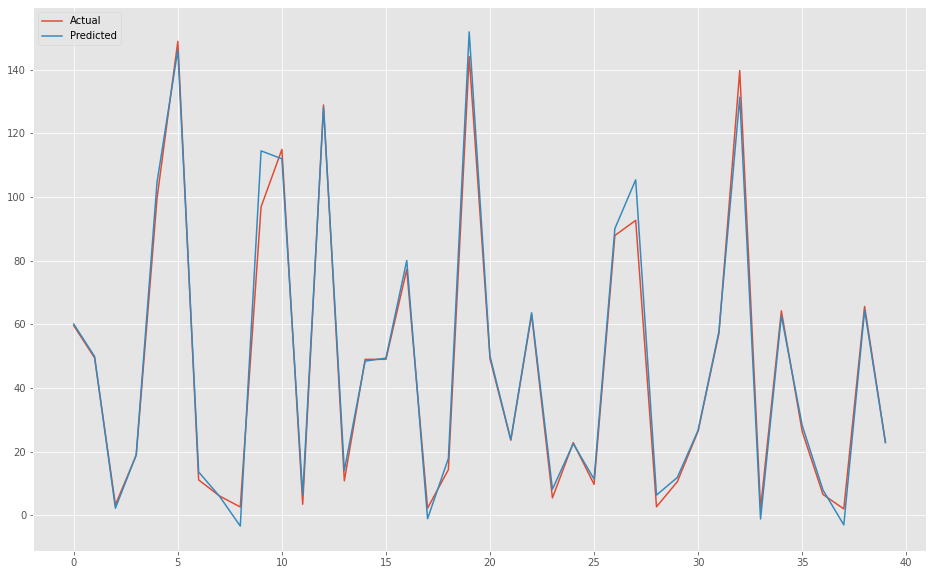

In [287]:
X_test = sm.tools.tools.add_constant(X_test, has_constant='add')
Y_test_p = mod.predict(X_test)
plt.figure(figsize=(16,10))
plt.plot(range(0,len(Y_test)),Y_test, label='Actual')
plt.plot(range(0,len(Y_test)),Y_test_p, label='Predicted')
plt.legend(loc='upper left')

### RSquared on the test data

In [288]:
r2_score(Y_test, Y_test_p)

0.9897430016710759

### Residuals and Assumption Validation

In [289]:
error = Y_test - Y_test_p

#### White Noise Residuals

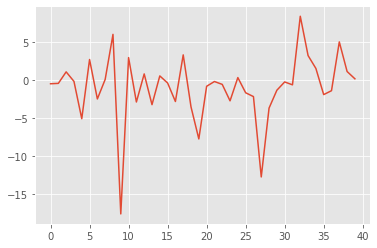

In [290]:
# plot the residuals
plt.plot(range(0,len(Y_test)),error)

Residuals are white noise with no real distribution.

#### No autocorrelation

<ipython-input-291-f1e1da0211d3>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acf.show()


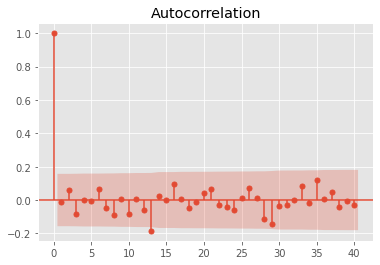

In [291]:
acf = smt.graphics.plot_acf(model.resid, lags=40 , alpha=0.05)
acf.show()
# there is no autocorrelation

**The Durbin-Watson test gives a value of ~2 which means there is no autocorrelation.**

There shows that there is no autocorrelation between the residuals, neither is their any particular distribution which means there is no variance escaping out of the model.

#### Heteroskedasticity Test

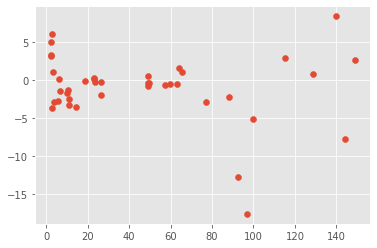

In [292]:
plt.scatter(Y_test,error)

No funnel or cone shaped pattern so no heteroskedasticity in the residuals.